
# 🧪 Four-Tank Process: Modeling, Control, and Robustification

This notebook implements and explains the **Four-Tank Process** control problem.  
We will cover:

- Nonlinear modeling  
- Linearization & transfer matrix  
- RGA-based loop pairing  
- Decentralized PI controller design  
- Robustification via loop shaping (Glover–McFarlane inspired scaling)  
- Simulation results (nonlinear closed-loop response)



## 1. 📖 Nonlinear Dynamics of the Four-Tank Process

The four-tank process has four interconnected tanks and two pumps.  
Control inputs are pump voltages \(u_1, u_2\).  
States are tank levels \(h_1, h_2, h_3, h_4\).

The governing equations are:

\begin{aligned}
\dot h_1 &= -\frac{a_1}{A}\sqrt{2gh_1} + \frac{a_3}{A}\sqrt{2gh_3} + \frac{\gamma_1 k_1}{A}u_1 \\
\dot h_2 &= -\frac{a_2}{A}\sqrt{2gh_2} + \frac{a_4}{A}\sqrt{2gh_4} + \frac{\gamma_2 k_2}{A}u_2 \\
\dot h_3 &= -\frac{a_3}{A}\sqrt{2gh_3} + \frac{(1-\gamma_2)k_2}{A}u_2 \\
\dot h_4 &= -\frac{a_4}{A}\sqrt{2gh_4} + \frac{(1-\gamma_1)k_1}{A}u_1
\end{aligned}

where  
- \(A\): tank cross-sectional area  
- \(a_i\): outlet hole area  
- \(k_i\): pump gain  
- \(\gamma_i\): flow distribution ratios  
- \(g\): gravity  


In [6]:

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from control import ss, tf
from numpy.linalg import inv, svd

g = 981.0  # cm/s^2

# --------------------------------------------------
# Four-Tank Nonlinear Model
# --------------------------------------------------
class FourTank:
    def __init__(self, A=15.52, kc=0.2, k1=3.3, k2=3.3,
                 a1=0.071, a2=0.057, a3=0.071, a4=0.057,
                 gamma1=0.625, gamma2=0.625):
        self.A, self.kc, self.k1, self.k2 = A, kc, k1, k2
        self.a1, self.a2, self.a3, self.a4 = a1, a2, a3, a4
        self.gamma1, self.gamma2 = gamma1, gamma2

    def dynamics(self, t, h, u):
        h1, h2, h3, h4 = h
        u1, u2 = u
        # prevent negative square roots
        h1, h2, h3, h4 = max(h1,0), max(h2,0), max(h3,0), max(h4,0)
        dh1 = (-self.a1/self.A)*np.sqrt(2*g*h1) + (self.a3/self.A)*np.sqrt(2*g*h3) + (self.gamma1*self.k1/self.A)*u1
        dh2 = (-self.a2/self.A)*np.sqrt(2*g*h2) + (self.a4/self.A)*np.sqrt(2*g*h4) + (self.gamma2*self.k2/self.A)*u2
        dh3 = (-self.a3/self.A)*np.sqrt(2*g*h3) + ((1-self.gamma2)*self.k2/self.A)*u2
        dh4 = (-self.a4/self.A)*np.sqrt(2*g*h4) + ((1-self.gamma1)*self.k1/self.A)*u1
        return [dh1, dh2, dh3, dh4]

    def simulate(self, h0, u_func, t_end=200, dt=0.1):
        t_eval = np.arange(0, t_end+dt/2, dt)
        def rhs(t, h):
            u = u_func(t, h) if callable(u_func) else u_func
            return self.dynamics(t, h, u)
        sol = solve_ivp(rhs, [0,t_end], h0, t_eval=t_eval, max_step=dt)
        return sol.t, sol.y

    def equilibrium_from_u(self, u):
        h0 = [5,5,2,2]
        _, h = self.simulate(h0, u, t_end=400, dt=0.2)
        return h[:,-1]

    def linearize_ss(self, h_eq):
        h1,h2,h3,h4 = [max(x,1e-6) for x in h_eq]
        T1 = self.A/self.a1*np.sqrt(2*h1/g)
        T2 = self.A/self.a2*np.sqrt(2*h2/g)
        T3 = self.A/self.a3*np.sqrt(2*h3/g)
        T4 = self.A/self.a4*np.sqrt(2*h4/g)
        A = np.array([
            [-1/T1,0,self.a3/(self.A*T3),0],
            [0,-1/T2,0,self.a4/(self.A*T4)],
            [0,0,-1/T3,0],
            [0,0,0,-1/T4]])
        B = np.array([
            [self.gamma1*self.k1/self.A,0],
            [0,self.gamma2*self.k2/self.A],
            [0,(1-self.gamma2)*self.k2/self.A],
            [(1-self.gamma1)*self.k1/self.A,0]])
        C = np.array([[self.kc,0,0,0],[0,self.kc,0,0]])
        D = np.zeros((2,2))
        return ss(A,B,C,D)

    def compute_rga(self, sys):
        G0 = np.array(sys.dcgain())
        return G0 * inv(G0).T

# Plot helpers
def plot_tank_levels(t,h,title="Tank Levels"):
    plt.figure(figsize=(8,4))
    for i in range(4):
        plt.plot(t,h[i],label=f"Tank {i+1}")
    plt.xlabel("t [s]"); plt.ylabel("Level [cm]")
    plt.title(title); plt.legend(); plt.grid(); plt.show()



## 2. ⚙️ Nonlinear Simulation


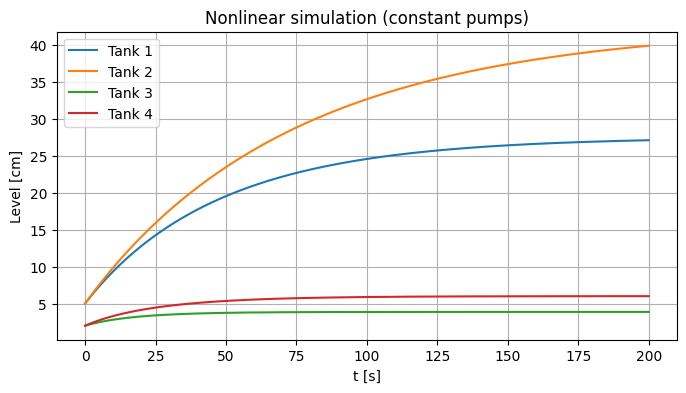

In [7]:

ft = FourTank()
u = [5,5]
h0 = [5,5,2,2]
t,h = ft.simulate(h0,u,200)
plot_tank_levels(t,h,"Nonlinear simulation (constant pumps)")



## 3. 📐 Linearization & RGA


In [8]:

h_eq = ft.equilibrium_from_u(u)
print("Equilibrium levels:",h_eq)
sys = ft.linearize_ss(h_eq)
RGA = ft.compute_rga(sys)
print("RGA:",RGA)


Equilibrium levels: [27.51776602 42.47840464  3.8709247   6.00594425]
RGA: [[ 1.00000605e+00 -6.04860046e-06]
 [-6.04860046e-06  1.00000605e+00]]



## 4. 🎛 PI Controller Design

We design decentralized PI controllers:

\[
K(s) = K_p \left(1 + \frac{1}{T_i s}\right)
\]

with heuristic tuning:

\[
K_p = \frac{0.8}{G(0)}, \quad T_i = \tau_i
\]


In [9]:

def pair_by_rga(RGA):
    diag_pref = abs(RGA[0,0]-1)+abs(RGA[1,1]-1)
    off_pref = abs(RGA[0,1]-1)+abs(RGA[1,0]-1)
    return [(0,0),(1,1)] if diag_pref<=off_pref else [(0,1),(1,0)]

def design_decentralized_PI(sys, pair=None, tau_i=20):
    if pair is None: 
        pair=[(0,0),(1,1)]
    G0 = np.array(sys.dcgain())
    K = np.empty((2,2), dtype=object)
    for i in range(2):
        for j in range(2):
            K[i,j] = None   # initialize with None

    for (y,u) in pair:
        gdc = G0[y,u]
        Kp = 0 if abs(gdc)<1e-6 else 0.8/gdc
        K[y,u] = tf([Kp*tau_i, Kp],[tau_i,0])  # proper PI transfer function
    return K

pairing = pair_by_rga(RGA)
Kdiag = design_decentralized_PI(sys, pair=pairing)
Kdiag


array([[TransferFunction(
        array([11.62698996,  0.5813495 ]),
        array([20,  0]),
        outputs=1, inputs=1)              , None],
       [None, TransferFunction(
              array([7.51287724, 0.37564386]),
              array([20,  0]),
              outputs=1, inputs=1)            ]], dtype=object)


## 5. 🛡 Robustification via Loop Shaping

We examine the sensitivity function:

\[
S(s) = (I + G(s)K(s))^{-1}
\]

Robustness metric:  
\[
M_s = \sup_\omega \bar\sigma(S(j\omega))
\]


In [10]:

def freq_grid(wmin=1e-3,wmax=1e2,points=200):
    return np.logspace(np.log10(wmin),np.log10(wmax),points)

def _eval_tf_at_omega(tf_sys,w):
    mag,phase,omega = tf_sys.freqresp([w])
    mag,phase = np.asarray(mag),np.asarray(phase)
    if mag.ndim==3:
        val = mag[:,:,0]*np.exp(1j*phase[:,:,0])
    else:
        val = mag[0]*np.exp(1j*phase[0])
    return np.squeeze(val)

def singular_values_at_freq(sys,Kdiag,w):
    Gf = np.squeeze(sys.freqresp([w])[0])
    Kmat = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            if Kdiag[i,j] is not None:
                Kmat[i,j]=_eval_tf_at_omega(Kdiag[i,j],w)
    I = np.eye(2)
    L = Gf@Kmat
    try:
        S = inv(I+L)
    except np.linalg.LinAlgError:
        return np.array([np.nan,np.nan]),np.array([np.nan,np.nan])
    return svd(L,compute_uv=False),svd(S,compute_uv=False)

def peak_sensitivity(sys,Kdiag,wgrid=None):
    if wgrid is None: wgrid=freq_grid()
    peaks=[np.nanmax(singular_values_at_freq(sys,Kdiag,w)[1]) for w in wgrid]
    return float(np.nanmax(peaks))

def robustify_by_scaling(sys,Kdiag,target_peak=2.0):
    alphas=np.logspace(0,-2,30)
    best=None
    for a in alphas:
        Kscaled=np.empty((2,2),dtype=object)
        for i in range(2):
            for j in range(2):
                Kscaled[i,j]=None if Kdiag[i,j] is None else a*Kdiag[i,j]
        pk=peak_sensitivity(sys,Kscaled)
        if best is None or pk<best[1]:
            best=(Kscaled,pk,a)
        if pk<=target_peak: return Kscaled,pk,a
    return best

peak_before=peak_sensitivity(sys,Kdiag)
Krob,peak_after,alpha=robustify_by_scaling(sys,Kdiag)
print("Peak before:",peak_before,"after:",peak_after,"alpha=",alpha)


Peak before: 0.9999001690575124 after: 0.9999001690575124 alpha= 1.0


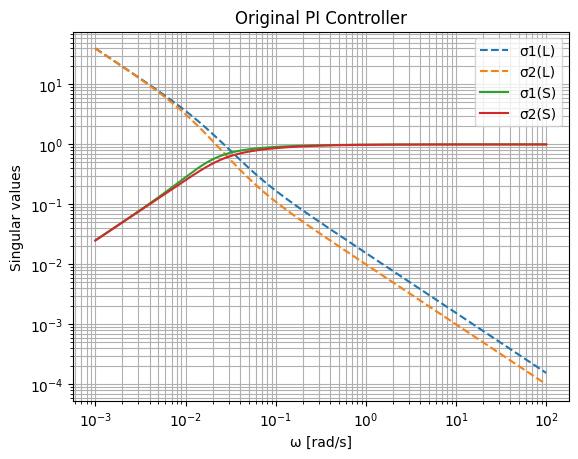

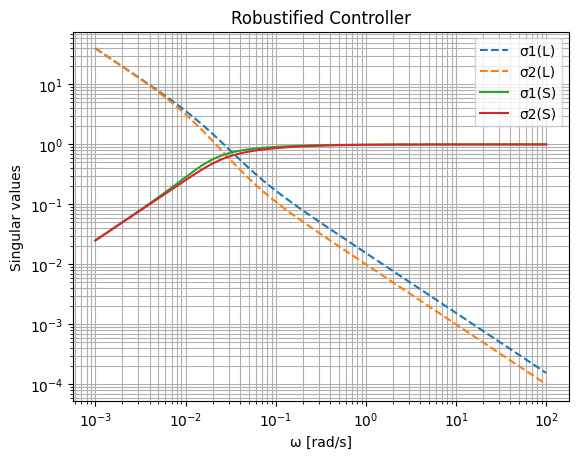

In [11]:

def plot_singular_values(sys,Kdiag,title=""):
    wgrid=freq_grid()
    sL1,sL2,sS1,sS2=[],[],[],[]
    for w in wgrid:
        sL,sS=singular_values_at_freq(sys,Kdiag,w)
        if np.isnan(sL).any(): continue
        sL1.append(sL[0]); sL2.append(sL[1])
        sS1.append(sS[0]); sS2.append(sS[1])
    plt.figure()
    plt.loglog(wgrid[:len(sL1)],sL1,'--',label='σ1(L)')
    plt.loglog(wgrid[:len(sL2)],sL2,'--',label='σ2(L)')
    plt.loglog(wgrid[:len(sS1)],sS1,'-',label='σ1(S)')
    plt.loglog(wgrid[:len(sS2)],sS2,'-',label='σ2(S)')
    plt.xlabel("ω [rad/s]"); plt.ylabel("Singular values")
    plt.title(title); plt.grid(which="both"); plt.legend(); plt.show()

plot_singular_values(sys,Kdiag,"Original PI Controller")
plot_singular_values(sys,Krob,"Robustified Controller")



## 6. Closed-Loop Nonlinear Simulation


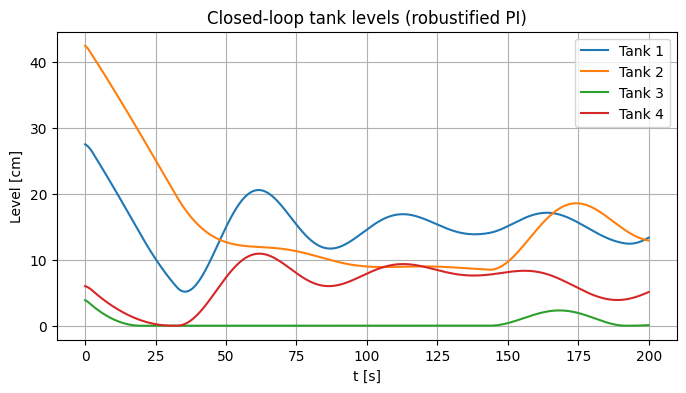

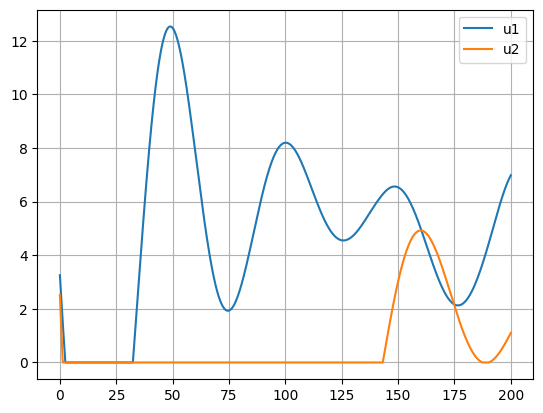

In [12]:

# Extract PI gains from robustified Krob
Kp=np.zeros((2,2)); Ki=np.zeros((2,2))
for i in range(2):
    for j in range(2):
        if Krob[i,j] is not None:
            num=np.squeeze(Krob[i,j].num)
            den=np.squeeze(Krob[i,j].den)
            if len(num)==2 and len(den)==2:
                Kp[i,j]=num[1]
                Ki[i,j]=num[0]/den[0]

setpoint=np.array([15,15]) # cm
t_end,dt=200,0.2
t=np.arange(0,t_end+dt/2,dt)
h_hist=np.zeros((4,len(t)))
u_hist=np.zeros((2,len(t)))
integ=np.zeros(2)
u_eq=np.array([5,5])
u_curr=u_eq.copy()
h=h_eq.copy()
for k,tk in enumerate(t):
    h_hist[:,k]=h
    y=np.array([ft.kc*h[0],ft.kc*h[1]])
    e=ft.kc*setpoint - y
    du=np.zeros(2)
    for (yi,uj) in pairing:
        integ[uj]+=e[yi]*dt
        du[uj]+=Kp[yi,uj]*e[yi]+Ki[yi,uj]*integ[uj]
    u_curr=np.clip(u_eq+du,0,15)
    u_hist[:,k]=u_curr
    sol=solve_ivp(lambda t_,x: ft.dynamics(t_,x,u_curr),[0,dt],h,max_step=dt)
    h=sol.y[:,-1]

plot_tank_levels(t,h_hist,"Closed-loop tank levels (robustified PI)")
plt.figure();plt.plot(t,u_hist[0],label="u1");plt.plot(t,u_hist[1],label="u2");plt.legend();plt.grid();plt.show()



## 7. Conclusion

- The four-tank process illustrates **MIMO control challenges**.  
- **RGA** helps select loop pairings.  
- Decentralized PI controllers can be tuned heuristically.  
- Robustification by scaling reduces sensitivity peak.  
- Nonlinear closed-loop simulations validate stability and performance.  
